# Create emulator (neural network) 

## Import modules

In [3]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker

# Keras modules 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import keras.backend as K
from scipy import stats
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


## Read the simulations.csv file and create inputdata array

In [4]:
# Read data from file 'simulations.csv' 
# Then arrange ncely the data in dataframe and change data type of the values
data = pd.read_csv("./simulations.csv", header=None)
#d=data.reset_index()

line0 = data.iloc[0,0]

param_names=[21]

param_names[0] = 'RKDN'
param_names[1:] = re.findall( r'( .*?)=', line0)
param_values = re.findall( r'=(.*?\d.*?e.*?0\d)', line0)
[float(param_values[k]) for k in range(len(param_values)-1)]

df_params = pd.DataFrame(param_values, index=param_names)
df_params[0] = df_params[0].astype(float)

L=len(data)
i=1
while i<L:
    line = data.iloc[i,0]
    param_values2 = re.findall( r'=(.*?\d.*?e.*?0\d)', line)
    [float(param_values2[l]) for l in range(len(param_values2)-1)]
    df_params[str(i)]=(param_values2)
    df_params[str(i)] = df_params[str(i)].astype(float)
    i = i+1

tmp_inputdata = df_params 

#Delete lines corresponding to the missing simulations 
missing_lines=pd.read_csv('missing_lines_simulations.txt', sep=" ", header = None)
length=missing_lines.count(axis='columns').values
l=length[0]
list_line=[l]

j=0
while j<l:
    line=missing_lines[j]-1
    list_line[j:]=line.astype(str)   
    j = j+1

tmp=tmp_inputdata.drop(list_line,axis=1).transpose() 

# Add index 'ensemble' as in the output data
a=len(tmp)
ensemble = [k for k in range(a)]
[str(ensemble[m]) for m in range(len(ensemble)-1)]
tmp['ensemble']=ensemble
inputdata=tmp.set_index('ensemble')
inputdata

,RKDN,RKDX,TENTR,TENTRX,VVX,RAUTEFR,RAUTEFS,RQICRMIN,RQICRMAX,RQLCR,...,TFVL,RACCEF,RRIMEF,RAGGEF,REVASX,RREVASXCS,RSWINHF_LIQ,RSWINHF_ICE,RLWINHF_LIQ,RLWINHF_ICE
ensemble,,,,,,,,,,,,,,,,,,,,,
0,0.000050,0.000587,0.000010,0.000058,-32.5,0.00206,0.00350,1.100000e-07,0.000011,0.000147,...,0.07010,1.130,0.991,0.288,1.050000e-07,0.5950,0.646,0.864,0.584,0.603
1,0.000020,0.000180,0.000019,0.000108,-47.1,0.00170,0.00152,1.030000e-07,0.000031,0.000779,...,0.19300,1.300,0.752,0.343,8.130000e-08,0.0236,0.655,0.792,0.502,0.781
2,0.000028,0.000138,0.000018,0.000071,-48.9,0.00384,0.00379,2.010000e-07,0.000023,0.000839,...,0.15300,0.570,1.230,0.168,5.810000e-07,0.8230,0.697,0.802,0.940,0.953
3,0.000038,0.000163,0.000017,0.000110,-44.5,0.00481,0.00221,9.700000e-08,0.000020,0.000057,...,0.00959,1.460,0.612,0.808,3.370000e-07,0.2230,0.745,0.633,0.927,0.672
4,0.000036,0.000787,0.000005,0.000056,-38.1,0.00195,0.00494,6.850000e-08,0.000029,0.000736,...,0.17000,1.410,1.580,0.596,4.370000e-07,0.8390,0.807,0.783,0.719,0.530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,0.000048,0.000261,0.000017,0.000066,-25.9,0.00281,0.00358,2.500000e-07,0.000043,0.000239,...,0.16800,0.852,1.070,0.318,2.340000e-07,0.1230,0.703,0.663,0.765,0.857
192,0.000047,0.000530,0.000008,0.000049,-44.0,0.00361,0.00474,9.120000e-08,0.000041,0.000587,...,0.00176,0.592,1.640,1.120,9.050000e-07,0.5420,0.898,0.992,0.914,0.748
193,0.000021,0.000831,0.000010,0.000064,-20.1,0.00331,0.00445,1.630000e-07,0.000038,0.000748,...,0.08220,1.470,1.370,1.280,6.980000e-07,0.8420,0.549,0.941,0.531,0.754


In [3]:
# Save the numpy array in a file   
inp=inputdata.values
np.save('/data/home/globc/peatier/CNRMppe/inputdata_file.npy', inp)

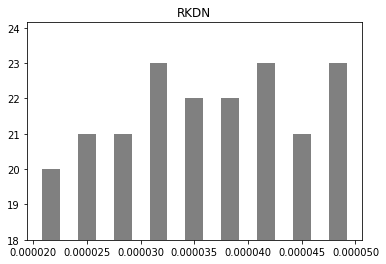

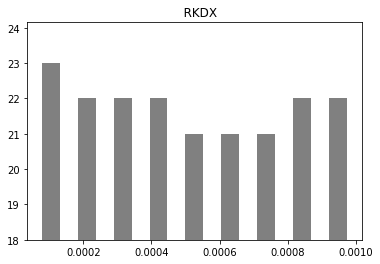

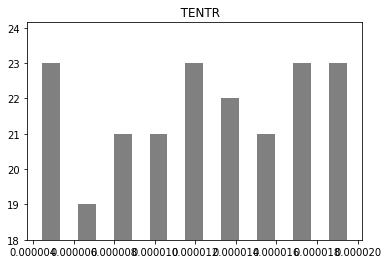

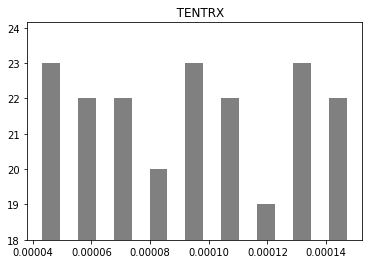

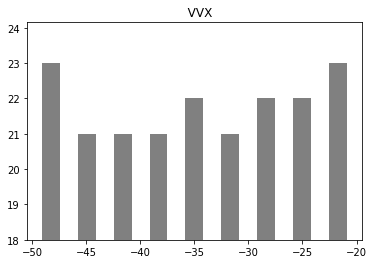

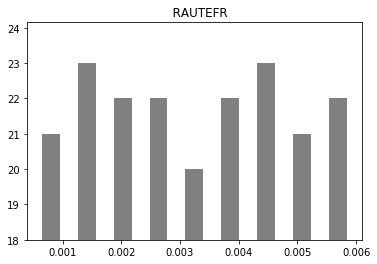

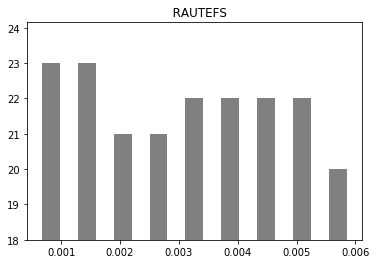

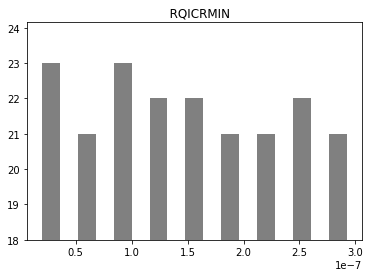

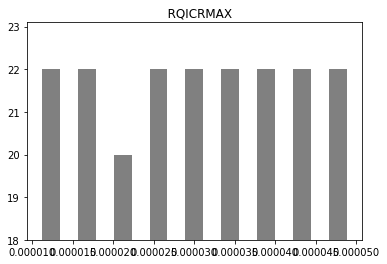

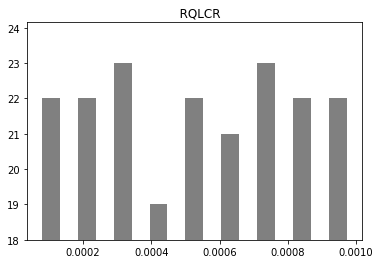

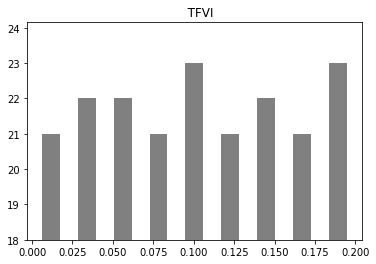

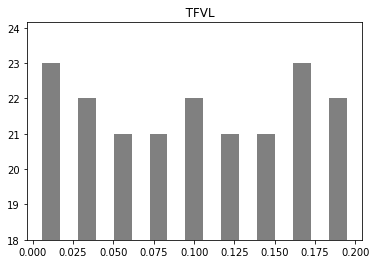

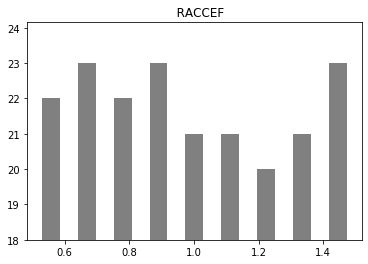

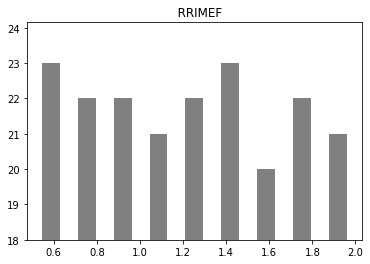

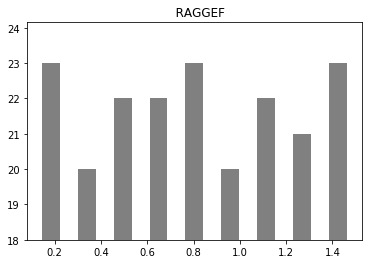

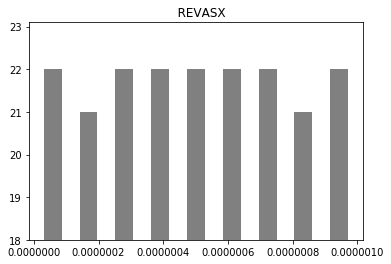

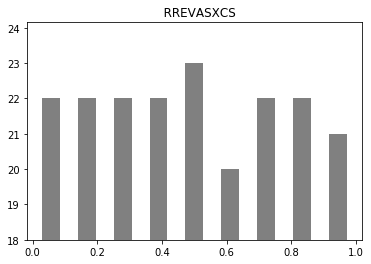

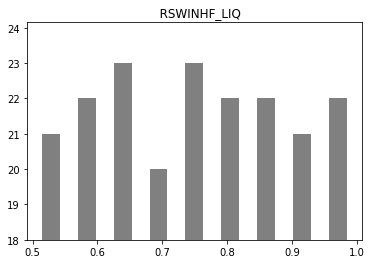

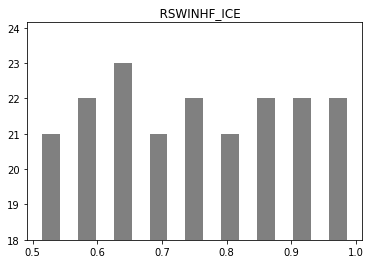

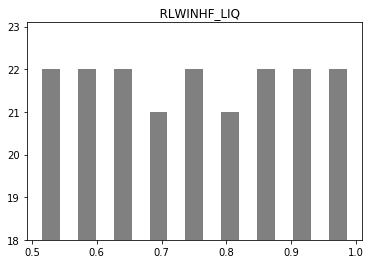

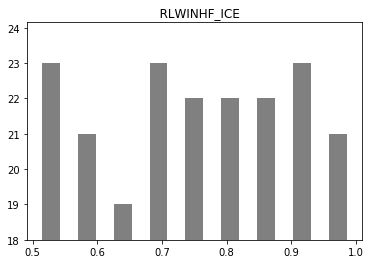

In [5]:
#Create plot

fig_params=plt.figure()
#Xaxis=np.arange(0,210,10)
#print(Xaxis)

# boucle pour céer les figures:
i=0
p=1
while i < 21:
#    ax = fig_params.add_subplot(21,1,p)
    param=param_names[i]
#    ax.set_title(param, fontsize=18, fontweight='bold')
#    inputdata.plot(kind='bar',y=param, ax=ax, fontsize=18, sharex=True)
#    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=20))
    plt.hist(inputdata.iloc[:,i], bins='auto', rwidth=0.5, color = "gray")
    plt.ticklabel_format(axis='x',useOffset=True,style='scientific')
    plt.ylim(ymin=18)
    plt.title(param)
    plt.show()
    i = i+1
    p = p+1

fig_params.suptitle('Perturbed parameters', fontsize=25, fontweight = 'bold')
fig_params.tight_layout()
fig_params.subplots_adjust(top=0.97,hspace = 0.2)

## Read /PRE623TUN*.nc and create outputdata array

In [5]:
# -------------------------------------  Simulations :  -----------------------------------------------------
path_simul = "/scratch/globc/dcom/ARPEGE6_TUNE"
filename_simul = "/PRE623TUN*.nc"
file_simul = xr.open_mfdataset(path_simul+filename_simul,concat_dim='ensemble',combine='nested')

# TOA fluxes
var = ['tas']
nc_simul = file_simul[var]
# compute global mean... WARNING : no scale factors used here !
xarray_simul = nc_simul.mean('lat').mean('lon')
simul = xarray_simul.to_dataframe()
#simul

OSError: no files to open

In [5]:
# Compute climatology
sim = simul.reset_index(level=['time'])
sim['month'] = pd.DatetimeIndex(sim['time']).month
outputdata=sim.groupby(['ensemble','month']).mean()
output=sim.groupby(['ensemble','month']).mean()
outputdata=output.groupby(['ensemble']).mean()
outputdata

,rlut
ensemble,
0,228.311859
1,222.054871
2,223.350296
3,226.556885
4,225.910217
...,...
191,222.314301
192,223.451294
193,222.339432


In [6]:
# Save the numpy array in a file   
out=outputdata.values
np.save('/data/home/globc/peatier/CNRMppe/outputdata_file.npy', out)

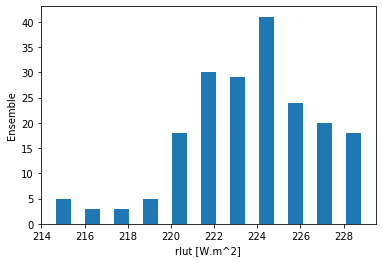

In [28]:
#Create plot 
plt.hist(outputdata['rlut'], bins='auto', rwidth=0.5)
#plt.title('rlut')
plt.xlabel('rlut [W.m^2]')
plt.ylabel('Ensemble')
plt.show()

## Create Emulator

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 20)                440       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
Train on 60 samples, validate on 136 samples
Epoch 1/50
60/60 [==============================] - 1s 14ms/step - loss: 41000203620.8119 - mean_error: 37703683452.7253 - val_loss: 12976587038.1176 - val_mean_error: 31046886.9706
Epoch 2/50
60/60 [==============================] - 0s 362us/step - loss: 26258882901.3333 - mean_error: 58875811.3333 - val_loss: 48900217795.7647 - val_mean_error: 103234654.2353
Epoch 3/50
60/60 [==============================] - 0s 361us/step - loss: 70355679232.0000 - mean_error: 138831864.0000 - val_loss: 

60/60 [==============================] - 0s 403us/step - loss: 3066825670656.0000 - mean_error: 22572843.0000 - val_loss: 3082977542144.0000 - val_mean_error: 21302334.0588
Epoch 43/50
60/60 [==============================] - 0s 403us/step - loss: 3093973128533.3335 - mean_error: 19689873.3333 - val_loss: 3108997169152.0000 - val_mean_error: 17046615.6471
Epoch 44/50
60/60 [==============================] - 0s 405us/step - loss: 3119213401429.3335 - mean_error: 14796774.8333 - val_loss: 3133165535232.0000 - val_mean_error: 11534113.8824
Epoch 45/50
60/60 [==============================] - 0s 402us/step - loss: 3142641035946.6665 - mean_error: 9236340.9167 - val_loss: 3155574128640.0000 - val_mean_error: 6173199.9412
Epoch 46/50
60/60 [==============================] - 0s 404us/step - loss: 3164346864981.3335 - mean_error: 4354901.6667 - val_loss: 3176312340480.0000 - val_mean_error: 2155605.3419
Epoch 47/50
60/60 [==============================] - 0s 407us/step - loss: 3184417832960.00

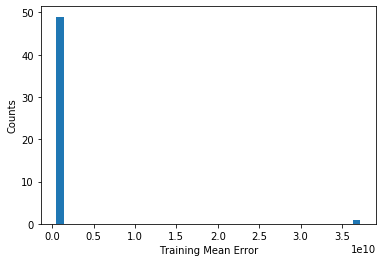

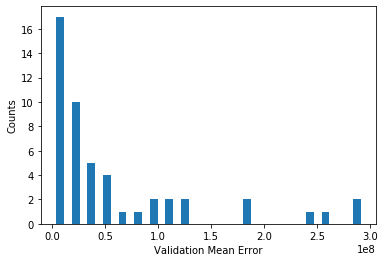

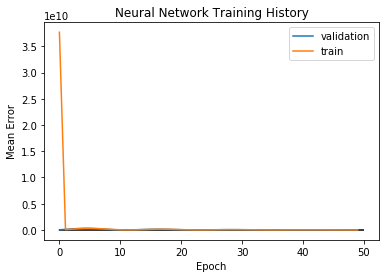

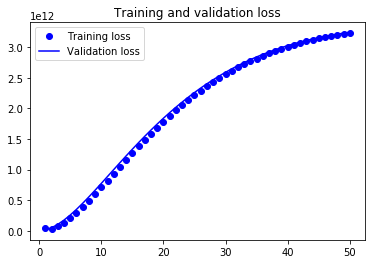

In [16]:
# Read in input array
inputdata = np.load(file="inputdata_file.npy")

# List of input variables
in_vars = param_names

# Read in outputdata array
outputdata = np.load("outputdata_file.npy")

# Create 2-layer simple model
model = Sequential()
# first layer with 20 nodes and rectified linear activation
# specify input_dim as number of parameters, not number of simulations
# l2 norm regularizer
model.add(Dense(20, input_dim=inputdata.shape[1], activation='relu',
    kernel_regularizer=l2(.001)))
# output layer with linear activation
model.add(Dense(1))

# Define model metrics
def mean_error(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

# Compile model
#model.compile(optimizer='adam',loss='mse',metrics=[mean_error])
#model.compile(optimizer='adam',loss='mse',metrics=[mean_pred])

# using a stochastic gradient descent optimizer
opt_dense = SGD(lr=0.001, momentum=0.99, decay=1e-4, nesterov=True)
model.compile(opt_dense, "mse", metrics=[mean_error])
model.summary()

# Separate training/test data: 60/40 split
# how does test split into validation/verification? try 20/20
x_train = inputdata[0:60,:]
x_test = inputdata[60:,:]
#x_val = inputdata[80:,:]
y_train = outputdata[0:60]
y_test = outputdata[60:]
#y_val = outputdata[80:]

# Fit the model
#model.fit(x_train, y_train, epochs=20, batch_size=10)
#model.fit(x_train, y_train, epochs=40, batch_size=10)
#print(model)
results = model.fit(x_train, y_train, epochs=50, batch_size=10,
        validation_data=(x_test,y_test))

#print(results.history)
print("Training Mean Error:", results.history['mean_error'][-1])
print("Validation Mean Error:", results.history['val_mean_error'][-1])

# Plot histogram of model mean error
plt.hist(results.history['mean_error'], bins=20, rwidth=0.5)
plt.xlabel('Training Mean Error')
plt.ylabel('Counts')
#plt.savefig("dist_train_me.eps")
plt.show()

# Plot histogram of validation mean error
plt.hist(results.history['val_mean_error'], bins=20, rwidth=0.5)
plt.xlabel('Validation Mean Error')
plt.ylabel('Counts')
#plt.savefig("dist_val_me.eps")
plt.show()


# Plot training history by epoch
plt.plot(results.epoch, results.history['val_mean_error'], label='validation')
plt.plot(results.epoch, results.history['mean_error'], label='train')
#plt.xticks(results.epoch)
plt.legend()
plt.hlines(y=0,xmin=0,xmax=50)
plt.ylabel('Mean Error')
plt.xlabel('Epoch')
plt.title('Neural Network Training History')
#plt.savefig("train_history.eps")
plt.show()


# Plot the loss function
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [39]:
# Evaluate the model using test data
#score = model.evaluate(x_test, y_test, batch_size=10)
#print("\n%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
#print(score)

# Make predictions - using validation subsection?
#predictions = model.predict(inputdata)
#predictions = model.predict(x_val)
#print(predictions)
#model_preds = model.predict(x_test)[:,0]

# model metric for predictions
#def model_error_preds(y_true,y_pred):
#    return np.mean(y_true-y_pred)

# calculate model mean error with predictions
#model_me = model_error_preds(y_test, model_preds)
#print("Prediction Mean Error: ", model_me)

# plot histogram of prediction error
#plt.hist(y_test-model_preds, bins=10)
#plt.xlabel('Prediction Error')
#plt.ylabel('Counts')
#plt.savefig("dist_preds.eps")
#plt.show()

# scatterplot actual versus predicted (validation set)
#plt.scatter(y_test, model_preds)
#plt.xlabel('Model Output GPP')
#plt.ylabel('Predicted GPP')
#plt.xlim(1.7,2.7)
#plt.ylim(1.7,2.7)
# trying to get a 1:1 line to show up (doesn't work)
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#plt.savefig("validation_scatter.eps")
#plt.show()

# linear regression of actual vs predicted
#slope, intercept, r_value, p_value, std_err = stats.linregress(y_test,
#                model_preds)
#print("r-squared:", r_value**2)

# Model interpretation by permutation variable importance
#def variable_importance(model, data, labels, input_vars, score_func, num_iters=10):
#    preds = model.predict(data)[:, 0]
#    score_val = score_func(labels, preds)
#    indices = np.arange(data.shape[0])
#    imp_scores = np.zeros((len(input_vars), num_iters))
#    shuf_data = np.copy(data)
#    for n in range(num_iters):
#        print(n)
#        np.random.shuffle(indices)
#        for v, var in enumerate(input_vars):
#            print(var)
#            shuf_data[:, v] = shuf_data[indices, v]
#            shuf_preds = model.predict(shuf_data)[:, 0]
#            imp_scores[v, n] = score_func(labels, shuf_preds)
#            shuf_data[:, v] = data[:, v]
#    return score_val - imp_scores

#model_imp_scores = variable_importance(model, x_test, y_test, in_vars,
#        model_error_preds, num_iters=3)
#model_mean_scores = model_imp_scores.mean(axis=1)
#for v, var in enumerate(in_vars):
#    print(var, model_mean_scores[v])

# Visualize what input most activates the output layer through feature
# optimization
#out_diff = K.mean((model.layers[-1].output - 1) ** 2)
#grad = K.gradients(out_diff, [model.input])[0]
#grad /= K.maximum(K.sqrt(K.mean(grad ** 2)), K.epsilon())
#iterate = K.function([model.input, K.learning_phase()],
#        [out_diff, grad])
#input_img_data = np.zeros(shape=(1, len(in_vars)))
#print(input_img_data.shape)

#for i in range(20):
#    out_loss, out_grad = iterate([input_img_data, 0])
#    input_img_data -= out_grad * 0.1
#    print(out_loss, out_grad.max())

# Plot the output layer feature optimization
#not working right now - input data is wrong size 
#plt.pcolormesh(input_img_data[0,0] * scaling_values.loc[0,"std"] +
#        scaling_values.loc[0,"mean"], vmin=-10, vmax=80,
#        cmap="gist_ncar")
#plt.colorbar()
#plt.quiver(input_img_data[0,-2]*scaling_values.loc[1,"std"] + 
#        scaling_values.loc[1,"mean"], 
#        input_img_data[0,-1]*scaling_values.loc[2,"std"] + 
#        scaling_values.loc[2,"mean"], scale=500)
#plt.title("Neural Net Output Layer Feature Optimization")
#plt.show()

#plt.pcolormesh(input_img_data[0,0], vmin=-5, vmax=5, cmap="RdBu_r")
#plt.quiver(input_img_data[0,1], input_img_data[0,2], scale=100)
#plt.show()

# Visualize the distribution of model weights in the output layer
#plt.hist(model.layers[-2].get_weights()[0], bins=50)
#plt.xlabel("Neural Net Output Layer Weights")
#plt.ylabel("Counts")
#plt.show()